# Rainfall maps from CML data

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import xarray as xr
import pycomlink as pycml
import matplotlib.pyplot as plt
import numpy as np
import opensense_data_downloader_and_transformer as oddt
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.3.0


In [4]:
# function from OpenSense sandbox https://github.com/OpenSenseAction/OPENSENSE_sandbox/blob/main/notebooks/Explore_existing_datasets.ipynb
oddt.download_andersson_2022_OpenMRG(
    local_path="data/andersson_2022_OpenMRG/", print_output=True
)

File already exists at desired location data/andersson_2022_OpenMRG/OpenMRG.zip
Not downloading!


In [22]:
# function from sandbox
cmls = oddt.transform_andersson_2022_OpenMRG(
    fn="data/andersson_2022_OpenMRG/OpenMRG.zip",
    path_to_extract_to="data/andersson_2022_OpenMRG/",
    time_start_end=(
        "2015-08-20",
        None,
    ),  # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
).isel(sublink_id=0)

/bg/home/graf-m/notebooks/cml_method_comparison/waa_comparison/opensense_data_downloader_and_transformer.py:303: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds_multindex = ds.assign_coords({'sublink':df_metadata.index})


In [23]:
# calculate total loss
cmls["tl"] = cmls.tsl - cmls.rsl
# seperate periods of rain from dry time steps
cmls["wet"] = cmls.tl.rolling(time=360, center=True).std(skipna=False) > 0.8
# estiamte the baseline during rain events
cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=cmls.tl,
    wet=cmls.wet,
    n_average_last_dry=30,
)
# compenmsate for wet antenna attenuation
cmls["waa"] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cmls.tl,
    baseline=cmls.baseline,
    wet=cmls.wet,
    waa_max=2.2,
    delta_t=1,
    tau=15,
)
# calculate attenuation caused by rain and remove negative attenuation
cmls["A"] = cmls.tl - cmls.baseline - cmls.waa
cmls["A"].values[cmls.A < 0] = 0
# derive rain rate via the k-R relation
cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cmls.A,
    L_km=cmls.length.astype(float)/1000, # convert to km
    f_GHz=cmls.frequency/1000, # convert to GHz
    pol=cmls.polarization,
)

In [37]:
cmls_1h = cmls.R.resample(time='60min').mean()

In [48]:
# define timestep 
time = '2015-08-27T01:00'
# load radar reference data
ds_radar = oddt.transform_andersson_openMRG_radar(
    data_fn="data/andersson_2022_OpenMRG/radar/radar.nc")
ds_radar = ds_radar.resample(time='60min').mean()

# get the center of each CML
cmls_1h["lat_center"] = (cmls_1h.site_0_lat + cmls_1h.site_1_lat) / 2
cmls_1h["lon_center"] = (cmls_1h.site_0_lon + cmls_1h.site_1_lon) / 2

### 5.1 Inverse distance weighting (IDW)

In [49]:
# define the properties of the IDW algorithm
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15,  # <------------- number of neighbors
    p=2,  # <------------------ weighting parameter
    exclude_nan=True,  # <----- remove nan values from interpolation
    max_distance=0.4,  # <----- upper bound distance
)

In [50]:
# interpolate one hour of rainfall using the lat and lon of the link midpoint. 
R_grid_idw = idw_interpolator(
    x=cmls_1h.lon_center,  # <------------------------- input x coordinates
    y=cmls_1h.lat_center,  # <------------------------- input y coordinates
    z=cmls_1h.sel(time=time),  # <----- rainfall values
    xgrid=radar_ref.lon.values,  # <--------- target grid x coordinates
    ygrid=radar_ref.lat.values,  # <--------- target grid y coordinates
)

In [51]:
radar_ref['R_grid_idw'] = (('y', 'x'), R_grid_idw)

### 5.2 Ordinary Kriging

In [52]:
kriging_interpolator = pycml.spatial.interpolator.OrdinaryKrigingInterpolator(
    nlags=6,
    variogram_model='spherical',
    #variogram_parameters=None,
    weight=True,
    n_closest_points=15,
)

In [57]:
R_grid_kriging = kriging_interpolator(
    x=cmls_1h.lon_center.where(~np.isnan(cmls_1h.sel(time=time)), drop = True), 
    y=cmls_1h.lat_center.where(~np.isnan(cmls_1h.sel(time=time)), drop = True), 
    z=cmls_1h.sel(time=time).where(~np.isnan(cmls_1h.sel(time=time)), drop = True),  # <----- rainfall values
    xgrid=radar_ref.lon.values,  # <--------- target grid x coordinates
    ygrid=radar_ref.lat.values,  # <--------- target grid y coordinates
)

In [58]:
radar_ref['R_grid_kriging'] = (('y', 'x'), R_grid_kriging)

### Plot IDW and Kriging results

ValueError: x must be one of None, 'x', 'y'. Received 'lon' instead.

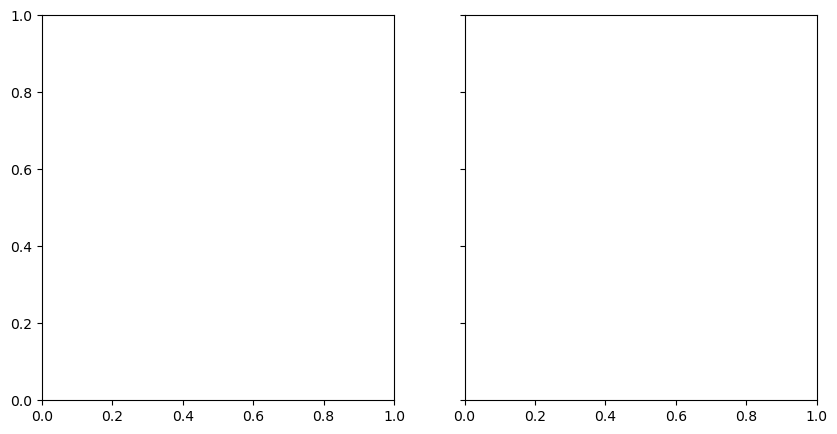

In [74]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)

for i,product in zip(range(2),["R_grid_idw","R_grid_kriging"]):
    plt.sca(ax[i])
    radar_ref[product].plot(cmap=plt.get_cmap("YlGnBu", 12),vmin=0,vmax=6,x='lon',y='lat')
    for cml_i in range(cmls.cml_id.size):
        plt.plot(
            [cmls_1h.isel(cml_id = cml_i).site_0_lon, 
             cmls_1h.isel(cml_id = cml_i).site_1_lon],
            [cmls_1h.isel(cml_id = cml_i).site_0_lat, 
             cmls_1h.isel(cml_id = cml_i).site_1_lat],
            "red",
            linewidth=1,
        )    

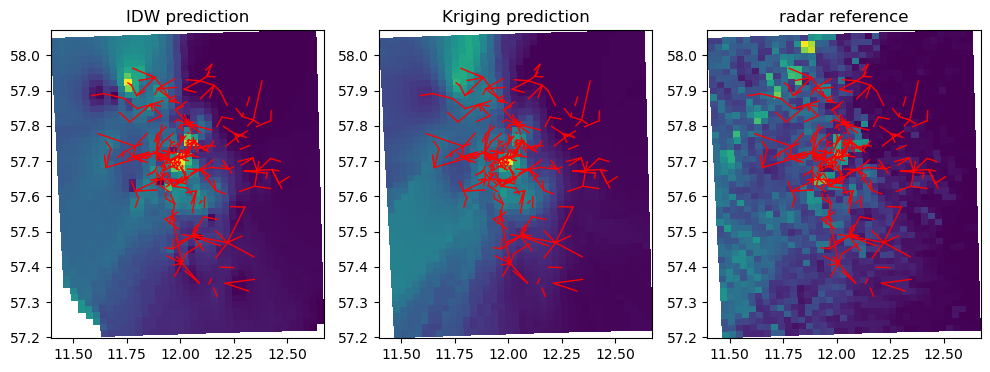

In [62]:
# such a 2-d array can be visulaized with matplotlibs pcolormesh function
fig, ax = plt.subplots(1, 3, figsize = (4*3, 4))
ax[0].set_title('IDW prediction')
ax[0].pcolormesh(radar_ref.lon.values, radar_ref.lat.values, R_grid_idw)
for cml_i in range(cmls.cml_id.size):
    ax[0].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )    

ax[1].set_title('Kriging prediction')
ax[1].pcolormesh(radar_ref.lon.values, radar_ref.lat.values, radar_ref['R_grid_kriging'])
for cml_i in range(cmls.cml_id.size):
    ax[1].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   

ax[2].pcolormesh(
    radar_ref.lon.values, 
    radar_ref.lat.values, 
    ds_radar.R.sel(time = time, method = 'nearest'),
    #cmap=plt.get_cmap("YlGnBu", 12),
)
for cml_i in range(cmls.cml_id.size):
    ax[2].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   
ax[2].set_title('radar reference');


# Comparing IWD and Kriging to the radar reference

In [22]:
# crop the radar and estimated rainfall fields so that we compare the interpolated pixels
radar_ref_crop = radar_ref.isel(x = slice(10, 30), y = slice(10, 40))

Text(0.5, 1.0, 'radar reference')

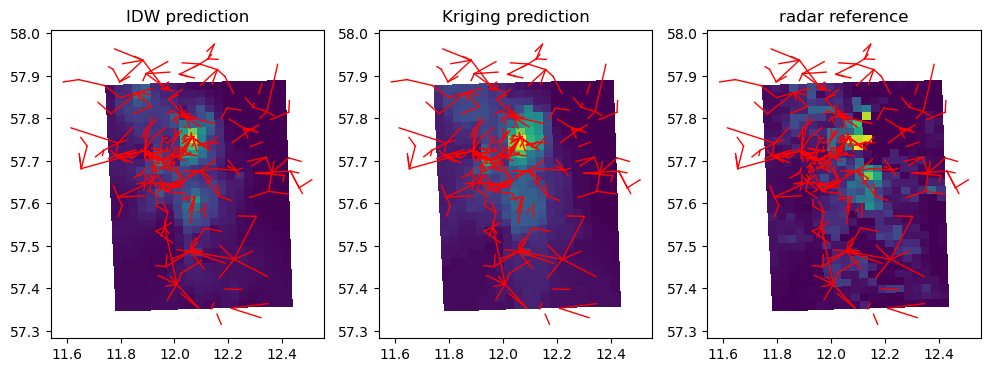

In [23]:
# such a 2-d array can be visulaized with matplotlibs pcolormesh function
fig, ax = plt.subplots(1, 3, figsize = (4*3, 4))
ax[0].set_title('IDW prediction')
ax[0].pcolormesh(radar_ref_crop.lon.values, radar_ref_crop.lat.values, radar_ref_crop.R_grid_idw)
for cml_i in range(cmls.cml_id.size):
    ax[0].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )    

ax[1].set_title('Kriging prediction')
ax[1].pcolormesh(radar_ref_crop.lon.values, radar_ref_crop.lat.values, radar_ref_crop.R_grid_kriging)
for cml_i in range(cmls.cml_id.size):
    ax[1].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   

ax[2].pcolormesh(
    radar_ref_crop.lon.values, 
    radar_ref_crop.lat.values, 
    radar_ref_crop.R.sel(time = time, method = 'nearest'),
    #cmap=plt.get_cmap("YlGnBu", 12),
)
for cml_i in range(cmls.cml_id.size):
    ax[2].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   
ax[2].set_title('radar reference');


Text(0.5, 1.0, 'Kriging')

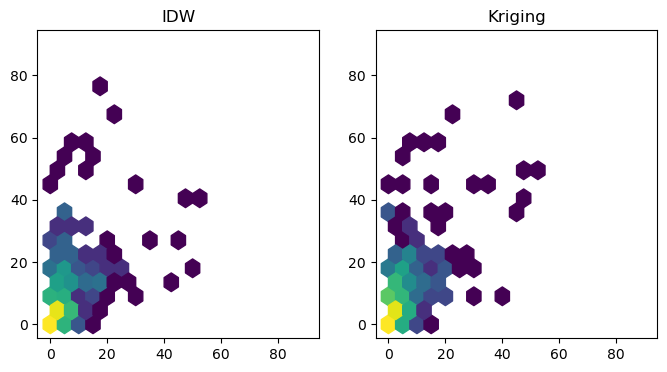

In [24]:
fig, ax = plt.subplots(1, 2, figsize= (8, 4))
ax[0].hexbin(
    radar_ref_crop.R.sel(time = time, method = 'nearest').values,
    radar_ref_crop.R_grid_idw.values,
    bins = 'log',
    gridsize = 18,
    extent = (0, 90, 0, 90),

)
ax[0].set_title('IDW')
ax[1].hexbin(
    radar_ref_crop.R.sel(time = time, method = 'nearest').values,
    radar_ref_crop.R_grid_kriging.values,
    bins = 'log',
    gridsize = 18,
    extent = (0, 90, 0, 90),
)
ax[1].set_title('Kriging');


# Exercises:

#### Exercise 1
Interpolate and plot another timestep of the dataset and compare it to the reference

#### Exercise 2
Compute and plot an aggregated rainfall map for the time interval '2015-08-27T01:00' -> '2015-08-27T02:00'. Hint: Resample the CML rainfall ammounts using (cmls.R.resample(time = '60T').sum() and radar data using radar_ref.resample(time = '60T').sum(). Then select the timestep of interest. Interpolate the aggregated CML values using IDW or Kriging. Compare the results to the reference using a scatterplot. How does different aggregation times affect the results? 

#### Exercise 3


Draw randomly 40 CMLs from timestep '2015-08-27T01:55'. Interpolate using IDW and Kriging. How does the interpolated maps from IDW and Kriging differ compared to the radar if you include more links? Hint: You can draw random integers by np.random.randint(0, 100, 40) and select them using cmls.isel(cml_id = np.random.randint(0, 100, 40)). 